<div class="align-center">
<a href="https://oumi.ai/"><img src="https://oumi.ai/docs/en/latest/_static/logo/header_logo.png" height="200"></a>

[![Documentation](https://img.shields.io/badge/Documentation-latest-blue.svg)](https://oumi.ai/docs/en/latest/index.html)
[![Discord](https://img.shields.io/discord/1286348126797430814?label=Discord)](https://discord.gg/oumi)
[![GitHub Repo stars](https://img.shields.io/github/stars/oumi-ai/oumi)](https://github.com/oumi-ai/oumi)
</div>

👋 Welcome to Open Universal Machine Intelligence (Oumi)!

🚀 Oumi is a fully open-source platform that streamlines the entire lifecycle of foundation models - from [data preparation](https://oumi.ai/docs/en/latest/resources/datasets/datasets.html) and [training](hhttps://oumi.ai/docs/en/latest/user_guides/train/train.html) to [evaluation](https://oumi.ai/docs/en/latest/user_guides/evaluate/evaluate.html) and [deployment](https://oumi.ai/docs/en/latest/user_guides/launch/launch.html). Whether you're developing on a laptop, launching large scale experiments on a cluster, or deploying models in production, Oumi provides the tools and workflows you need.

🤝 Make sure to join our [Discord community](https://discord.gg/oumi) to get help, share your experiences, and contribute to the project! If you are interested in joining one of the community's open-science efforts, check out our [open collaboration](https://oumi.ai/community) page.

⭐ If you like Oumi and you would like to support it, please give it a star on [GitHub](https://github.com/oumi-ai/oumi).

# Evaluation with Oumi

This notebook provides a guide for running end-to-end evaluations on your trained model using Oumi. Specifically, it explores how the performance of LLaMA models evolves as we scale from 1B to 3B and 8B parameters.

## Prerequisites and Environment

To conduct this evaluation, you will need to use AlpacaEval as one the backends. Begin by installing the [Alpaca Eval package](https://pypi.org/project/alpaca-eval/) to get started.


In [1]:
pip install -U -q alpaca_eval

Note: you may need to restart the kernel to use updated packages.


AlpacaEval 2.0 calculates win rates by comparing a model's responses to reference responses. This process requires an annotator, with the default being [GPT-4 Turbo](https://github.com/tatsu-lab/alpaca_eval?tab=readme-ov-file#alpacaeval-20). To access the latest GPT-4 models, an OpenAI API key is necessary. You can find instructions for creating an OpenAI account and generating an API key on [OpenAI's quickstart webpage](https://platform.openai.com/docs/).

In [2]:
import os

os.environ["OPENAI_API_KEY"] = ""  # Set your OpenAI API key here

<b>⚠️ Cost considerations</b>: The cost of running a standard AlpacaEval 2.0 evaluation and annotating 805 examples with GPT-4 Turbo is <b>$3.50</b>. You need to evaluate on the full dataset to reproduce the results presented in this notebook. However, if you are only interested in experimenting with the API, you can limit the evaluation to a smaller number of examples. For instance, annotating just 3 examples will cost less than <b>0.5¢</b>.

In [3]:
NUM_EXAMPLES = 3  # Replace with 805 for full dataset evaluation.

Finally, we will create a directory for the tutorial to store the results.

In [4]:
from pathlib import Path

tutorial_dir = "./output/evaluation_tutorial/TEST_OUMI"

Path(tutorial_dir).mkdir(parents=True, exist_ok=True)

## Experimental Setup

In this experiment, we aim to compare the performance of models as we scale their size. For this purpose, we have selected LLaMA models with `1B`, `3B`, and `8B` parameters. In the code snippet below, you can specify any model hosted on HuggingFace, provide a path to a local directory containing your model, or use any other model format supported by Oumi inference. Additionally, note that we restrict the maximum number of tokens for each model to `8192` in order to optimize both cost and resource usage.


In [5]:
MODEL_NAMES = [
    "meta-llama/Llama-3.2-1B-Instruct",
    "meta-llama/Llama-3.2-3B-Instruct",
    "meta-llama/Llama-3.1-8B-Instruct",
]
MODEL_MAX_TOKENS = 8192

To conduct a comprehensive evaluation of a model's performance, it is essential to assess it across a [diverse set of benchmarks](https://oumi.ai/docs/en/latest/user_guides/evaluate/standardized_benchmarks.html#trade-offs). At a minimum, a [standardized benchmark](https://oumi.ai/docs/en/latest/user_guides/evaluate/standardized_benchmarks.html) is required to evaluate the model's knowledge and reasoning capabilities, while a [generative benchmark](https://oumi.ai/docs/en/latest/user_guides/evaluate/generative_benchmarks.html) is necessary to assess the quality of responses and its ability to follow instructions. In this evaluation, we select [MMLU Pro](https://arxiv.org/abs/2406.01574) for its focus on challenging, reasoning-intensive knowledge tasks and [AlpacaEval 2.0](https://arxiv.org/abs/2404.04475) for assessing the overall quality of the generated responses. To customize the evaluation tasks, please see [our documentation](https://oumi.ai/docs/en/latest/user_guides/evaluate/evaluation_config.html#configuration-options). 

In [6]:
from oumi.core.configs import EvaluationTaskParams

TASKS = [
    EvaluationTaskParams(
        evaluation_platform="lm_harness",
        task_name="leaderboard_mmlu_pro",
    ),
    EvaluationTaskParams(
        evaluation_platform="alpaca_eval",
        num_samples=NUM_EXAMPLES,
    ),
]

## Evaluation

To perform evaluations with Oumi, we define an [EvaluationConfig](https://oumi.ai/docs/en/latest/user_guides/evaluate/evaluation_config.html) for each model with the tasks discussed above, along with the relevant [model](https://github.com/oumi-ai/oumi/blob/main/src/oumi/core/configs/params/model_params.py) and [generation](https://github.com/oumi-ai/oumi/blob/main/src/oumi/core/configs/params/generation_params.py) parameters. If the system is equipped with a GPU, we strongly recommend configuring the [inference engine](https://oumi.ai/docs/en/latest/api/oumi.core.configs.html#oumi.core.configs.InferenceEngineType) to `VLLM` for optimal performance.

The code snippet below illustrates how to run evaluations for our three models, storing the key metrics for each model in lists. Specifically, the length-controlled win rate for Alpaca is saved in `alpaca_lcwr`, while the accuracy for MMLU Pro is stored in `mmlu_acc`.

In [ ]:
from oumi.core.configs import (
    EvaluationConfig,
    GenerationParams,
    InferenceEngineType,
    ModelParams,
)
from oumi.evaluate import evaluate

# Store the results for 1B, 3B, 8B models in the following lists.
mmlu_acc = []
alpaca_lcwr = []

for model_name in MODEL_NAMES:
    # Define the evaluation configuration.
    evaluation_config = EvaluationConfig(
        tasks=TASKS,
        model=ModelParams(model_name=model_name, model_max_length=MODEL_MAX_TOKENS),
        generation=GenerationParams(max_new_tokens=MODEL_MAX_TOKENS),
        inference_engine=InferenceEngineType.VLLM,
        output_dir=tutorial_dir,
    )

    # Evaluate the model.
    task_results = evaluate(evaluation_config)

    # Store the results.
    mmlu_acc.append(task_results[0]["results"]["leaderboard_mmlu_pro"]["acc,none"])
    alpaca_lcwr.append(task_results[1]["results"]["length_controlled_winrate"] / 100)

## Evaluation Results

The evaluation results are shown below.

In [8]:
print(mmlu_acc)
print(alpaca_lcwr)

[0.19772273936170212, 0.3041057180851064, 0.38040226063829785]
[0.0864114369219142, 0.1973881863510852, 0.24729342554633926]


When visualizing the results using `matplotlib`'s `pyplot`, we observe a clear trend: both the model's knowledge and reasoning abilities (measured by MMLU Pro) and the quality of its responses (measured by AlpacaEval 2.0) improve as the model size increases. A notable performance gain is observed when scaling from 1B to 3B parameters. However, beyond this, the rate of improvement begins to plateau, indicating diminishing returns with further increases in model size.

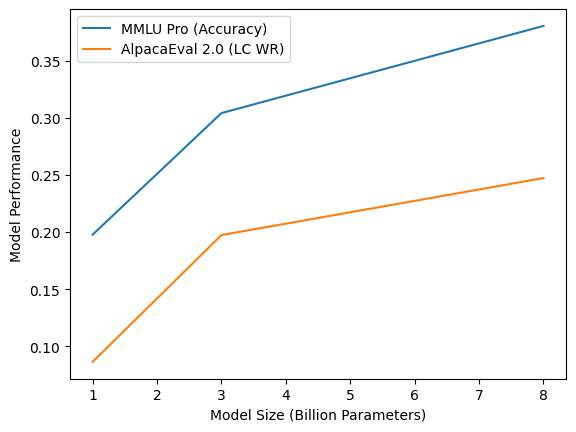

In [9]:
import matplotlib.pyplot as plt

# Data
model_sizes = [1, 3, 8]
plt.plot(model_sizes, mmlu_acc, label="MMLU Pro (Accuracy)")
plt.plot(model_sizes, alpaca_lcwr, label="AlpacaEval 2.0 (LC WR)")

# Show
plt.xlabel("Model Size (Billion Parameters)")
plt.ylabel("Model Performance")
plt.legend()
plt.show()